Sumber : https://github.com/rubentea16/indo-bert-news-classification/blob/master/notebook/Indo_BERT_Fine_Tuning_News_Classification.ipynb

In [1]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil --q
!pip install psutil --q
!pip install humanize --q
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

ln: failed to create symbolic link '/usr/bin/nvidia-smi': No such file or directory


Gen RAM Free: 22.2 GB  | Proc size: 85.7 MB
GPU RAM Free: 7563MB | Used: 629MB | Util   8% | Total 8192MB


In [2]:
!pip install transformers --q

In [3]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 2080


In [4]:
import pandas as pd

In [5]:
data = pd.read_csv('dataset\query_compile_2023-12-16.csv')

In [6]:
list(data.intents.unique())

['desain',
 'pengumpulan',
 'variabel_indikator',
 'pengolahan_diseminasi',
 'salam_pembuka',
 'identitas',
 'salam_penutup']

In [7]:
# dict mapping
label2num = {'variabel_indikator':0, 'pengumpulan':1, 'pengolahan_diseminasi':2, 'identitas':3, 'desain':4,
             'salam_pembuka':5, 'salam_penutup':6}

In [8]:
train = data[data['split']=='train']
test = data[data['split']!='train']

In [9]:
# encode label
train.intents = train.intents.map(label2num)
test.intents = test.intents.map(label2num)

C:\Users\222011815\AppData\Local\Temp\ipykernel_24256\1445901131.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.intents = train.intents.map(label2num)
C:\Users\222011815\AppData\Local\Temp\ipykernel_24256\1445901131.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.intents = test.intents.map(label2num)


In [10]:
from nltk.tokenize import word_tokenize
import nltk
import collections
nltk.download('punkt')

def get_frequent_word(df):
    text = " ".join(list(df['query_mod_clean'].str.lower()))
    word_list = word_tokenize(text)
    word_count = dict(collections.Counter(word_list))
    d_word_freq = pd.DataFrame(data = {'word': list(word_count.keys()), 'freq': list(word_count.values())})

    return d_word_freq

def cleansing(text, stopword = None):
    word_list = word_tokenize(text.lower())
    word_list = [word for word in word_list if len(word) > 2]
    word_list = [word for word in word_list if word.isalnum()]
    if stopword == None:
        text = ' '.join(word_list)
    else:
        word_list = [word for word in word_list if word not in stopword]
        text = ' '.join(word_list)

    return text

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\222011815\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
# Get frekuensi kemunculan kata
d_w_f = get_frequent_word(train)
# Check alphanumeric
d_w_f['is_alnum'] = d_w_f.word.str.isalnum()
# select only alphanumeric word (ignore punctuation)
d_w_f_selected = d_w_f[d_w_f['is_alnum'] == True].sort_values(by = 'freq', ascending = False)
print(d_w_f_selected.head(15))
print(d_w_f_selected.tail(15))

           word  freq  is_alnum
3          yang  1028      True
5          pada   957      True
35        dalam   752      True
28        tahun   736      True
10       survei   568      True
46          apa   511      True
7          data   492      True
14          dan   439      True
22        untuk   301      True
106  perusahaan   238      True
147   bagaimana   222      True
69    kompilasi   215      True
70    statistik   213      True
45         2022   210      True
40     analisis   204      True
                 word  freq  is_alnum
38            mandiri     1      True
1440  representasinya     1      True
1436        substansi     1      True
1435      efektivitas     1      True
1433        ketepatan     1      True
1430          seratus     1      True
1421             kios     1      True
36           anjungan     1      True
1407           uraian     1      True
37              tunai     1      True
1403            norma     1      True
1402        tujuannya     1     

In [12]:
# Create stopwords list
stopwords = list(d_w_f_selected[(d_w_f_selected['freq'] > 5000) | (d_w_f_selected['freq'] < 2)].word)
print(stopwords[:10])

['direalisasikan', 'diartikulasikan', 'dirancang', 'agar', 'pengajuan', 'disebarkan', 'berupa', 'negeri', 'mancanegara', 'divisi']


In [13]:
len(stopwords)

425

In [14]:
from tqdm import tqdm

for i in tqdm(list(train.index)):
    train.loc[i, 'text_cleansing'] = cleansing(train.loc[i, 'query_mod_clean'], stopword=stopwords)

for i in tqdm(list(test.index)):
    test.loc[i, 'text_cleansing'] = cleansing(test.loc[i, 'query_mod_clean'], stopword=stopwords)

  0%|          | 0/1894 [00:00<?, ?it/s]

C:\Users\222011815\AppData\Local\Temp\ipykernel_24256\97623509.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[i, 'text_cleansing'] = cleansing(train.loc[i, 'query_mod_clean'], stopword=stopwords)
  0%|          | 0/474 [00:00<?, ?it/s]C:\Users\222011815\AppData\Local\Temp\ipykernel_24256\97623509.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[i, 'text_cleansing'] = cleansing(test.loc[i, 'query_mod_clean'], stopword=stopwords)
100%|██████████| 474/474 [00:00<00:00, 4600.64it/s]


In [15]:
# Training data only use 4000 sentences
sentences = train.query_mod_clean.values[:4000]
labels = train.intents.values[:4000]

# Testing data only use 1000 sentence
test_sentences = test.query_mod_clean.values[:1000]
test_labels = test.intents.values[:1000]

In [16]:
train[train['sub-intents']=='salam_pembuka']

,raw_index,intents,sub-intents,jenis,count,query,query_mod,query_mod_clean,split,text_cleansing
4,1116,5,salam_pembuka,salam_pembuka,73.0,"Apa kabar, chatbot yang cerdas? Bolehkah saya ...","Apa kabar, chatbot yang cerdas? Bolehkah saya ...",apa kabar chatbot yang cerdas bolehkah saya me...,train,apa kabar chatbot yang cerdas bolehkah saya me...
13,1300,5,salam_pembuka,salam_pembuka,137.0,good evening say,good evening say,good evening say,train,good evening say
18,1126,5,salam_pembuka,salam_pembuka,83.0,"Namaskar, chatbot. Ada pertanyaan yang ingin s...","Namaskar, chatbot. Ada pertanyaan yang ingin s...",namaskar chatbot ada pertanyaan yang ingin say...,train,namaskar chatbot ada pertanyaan yang ingin say...
25,1290,5,salam_pembuka,salam_pembuka,127.0,good morning chatbot,good morning chatbot,good morning chatbot,train,good morning chatbot
66,1049,5,salam_pembuka,salam_pembuka,6.0,"Selamat siang, chatbot! Bisakah Anda membantu ...","Selamat siang, chatbot! Bisakah Anda membantu ...",selamat siang chatbot bisakah anda membantu saya,train,selamat siang chatbot bisakah anda membantu saya
...,...,...,...,...,...,...,...,...,...,...
1841,1074,5,salam_pembuka,salam_pembuka,31.0,"Selamat siang, chatbot! Apa yang Anda ketahui ...","Selamat siang, chatbot! Apa yang Anda ketahui ...",selamat siang chatbot apa yang anda ketahui te...,train,selamat siang chatbot apa yang anda ketahui te...
1853,1273,5,salam_pembuka,salam_pembuka,110.0,hai,hai,hai,train,hai
1858,1127,5,salam_pembuka,salam_pembuka,84.0,"Selamat siang, chatbot yang terpercaya. Saya m...","Selamat siang, chatbot yang terpercaya. Saya m...",selamat siang chatbot yang terpercaya saya mem...,train,selamat siang chatbot yang terpercaya saya mem...
1872,1128,5,salam_pembuka,salam_pembuka,85.0,"Apa kabar, chatbot yang bijaksana? Bolehkah sa...","Apa kabar, chatbot yang bijaksana? Bolehkah sa...",apa kabar chatbot yang bijaksana bolehkah saya...,train,apa kabar chatbot yang bijaksana bolehkah saya...


In [17]:
from transformers import BertTokenizer

print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

Loading BERT tokenizer...


In [18]:
import statistics
sent_length = []

# For every sentence...
for sent in sentences:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    sent_length.append(len(input_ids))

print('Average length = ', sum(sent_length)/len(sent_length))
print('Median length = ', statistics.median(sent_length))

Average length =  17.438225976768745
Median length =  17.0


In [19]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 100,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Program Files\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  sarana atau moda yang dipakai pada pengumpulan data di pilot survei ilmu pengetahuan teknologi dan inovasi iptek dan inovasi  adalah
Token IDs: tensor([    2,  3269,   158, 23869,    34,  2453,   126,  8798,  1006,    26,
        11582,  7648,  1056,  1608,  1429,    41,  5976, 14065,    41,  5976,
          154,     3,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


In [20]:
# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[5])
print('Token IDs:', input_ids[5])

Original:  manfaat dan tujuan dari survei industri mikro dan kecil tahunan  dapat ditemukan dalam
Token IDs: tensor([   2, 1587,   41, 1052,   98, 7648, 1934, 6782,   41,  855, 6075,  173,
        2198,  112,    3,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])


In [21]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-20 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

1,515 training samples
  379 validation samples


In [22]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [23]:
import torch

torch.cuda.is_available()

True

In [24]:
torch. __version__

'2.1.1+cu118'

In [25]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    'indobenchmark/indobert-base-p1', # Use the 12-layer BERT model, with an cased vocab.
    num_labels = 7,
    output_attentions = False, # return attentions weights
    output_hidden_states = False, # returns all hidden-states
)

# Tell pytorch to run this model on the GPU.
# model.cuda()
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [26]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (50000, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [27]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8
                )

c:\Program Files\Python311\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [28]:
from transformers import get_linear_schedule_with_warmup

epochs = 3

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
print('Jumlah batch :', len(train_dataloader))
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Jumlah batch : 48


In [29]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [30]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [31]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# List variable for store training and validation loss, validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 20 batches.
        if step % 20 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a backward pass
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # token_type_ids is same as the "segment ids", which differentiates 
        # sentence 1 and 2 in sentence-pair tasks
        loss, logits = model(b_input_ids, 
                             token_type_ids=None,
                             attention_mask=b_input_mask, 
                             labels=b_labels,
                             return_dict=False)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. 
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode (batchnorm, dropout disable)
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Deactivate autograd, it will reduce memory usage and speed up computations
        # but you won’t be able to backprop (which you don’t want in an eval script).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels,
                                   return_dict=False)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'Epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Validation Loss': avg_val_loss,
            'Validation Accuracy': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    20  of     48.    Elapsed: 0:00:07.
  Batch    40  of     48.    Elapsed: 0:00:13.

  Average training loss: 1.10
  Training epoch took: 0:00:15

Running Validation...
  Accuracy: 0.91
  Validation Loss: 0.43
  Validation took: 0:00:01

======== Epoch 2 / 3 ========
Training...
  Batch    20  of     48.    Elapsed: 0:00:06.
  Batch    40  of     48.    Elapsed: 0:00:11.

  Average training loss: 0.23
  Training epoch took: 0:00:13

Running Validation...
  Accuracy: 0.98
  Validation Loss: 0.12
  Validation took: 0:00:01

======== Epoch 3 / 3 ========
Training...
  Batch    20  of     48.    Elapsed: 0:00:06.
  Batch    40  of     48.    Elapsed: 0:00:11.

  Average training loss: 0.07
  Training epoch took: 0:00:13

Running Validation...
  Accuracy: 0.99
  Validation Loss: 0.06
  Validation took: 0:00:01

Training complete!
Total training took 0:00:45 (h:mm:ss)


In [32]:
import pandas as pd

# Display floats with two decimal places.
# pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('Epoch')

# Display the table.
df_stats
     

,Training Loss,Validation Loss,Validation Accuracy,Training Time,Validation Time
Epoch,,,,,
1,1.102176,0.431104,0.906925,0:00:15,0:00:01
2,0.233665,0.116077,0.984375,0:00:13,0:00:01
3,0.066244,0.060235,0.994792,0:00:13,0:00:01


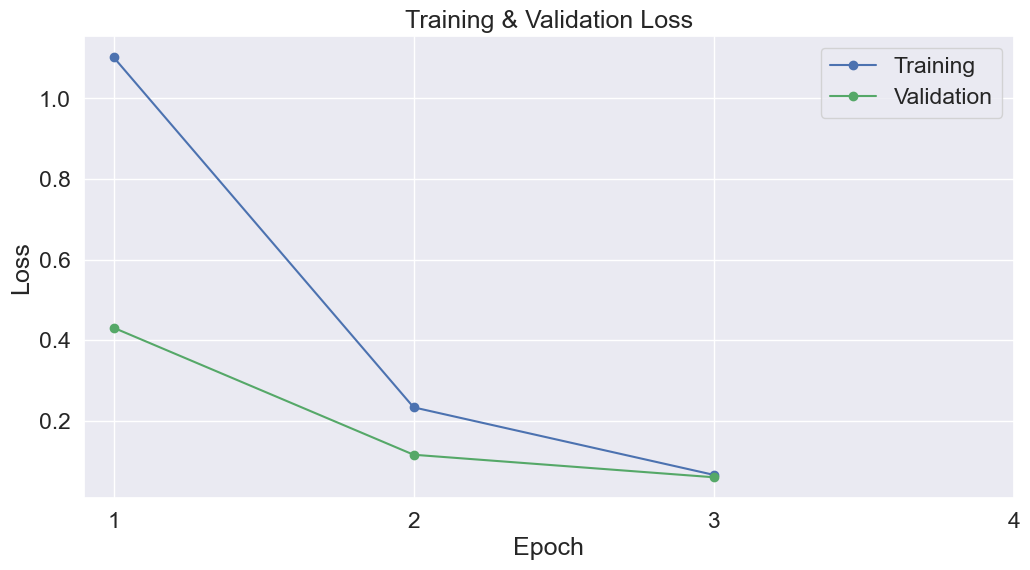

In [33]:
import matplotlib.pyplot as plt 
# % matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Validation Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [34]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in test_sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 100,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(test_labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

c:\Program Files\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [35]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 474 test sentences...
    DONE.


In [36]:
# Calculate accuracy for test dataset
total_accuracy = 0
for batch_num in range(len(predictions)): 
  total_accuracy += flat_accuracy(predictions[batch_num], true_labels[batch_num])

total_accuracy = total_accuracy/len(predictions)*100
print('Accuracy on test dataset:', total_accuracy)

Accuracy on test dataset: 99.16666666666667


In [37]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = 'model/classification/indoBERT-base-p1'

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to model/classification/indoBERT-base-p1


('model/classification/indoBERT-base-p1\\tokenizer_config.json',
 'model/classification/indoBERT-base-p1\\special_tokens_map.json',
 'model/classification/indoBERT-base-p1\\vocab.txt',
 'model/classification/indoBERT-base-p1\\added_tokens.json')

In [38]:
# Load a trained model and vocabulary that you have fine-tuned
model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [39]:
num2label = {0: 'variabel_indikator',
                1: 'pengumpulan',
                2: 'pengolahan_diseminasi',
                3: 'identitas',
                4: 'desain',
                5: 'salam_pembuka',
                6: 'salam_penutup'}

In [40]:

def predict_bert(query):
    input_ids = []
    attention_masks = []
    encoded_dict = tokenizer.encode_plus(
                            query,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 100,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                    )
        
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])
    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    # labels = torch.tensor(test_labels)

    # Set the batch size.  
    batch_size = 32  

    # Create the DataLoader.
    prediction_data = TensorDataset(input_ids, attention_masks)
    prediction_sampler = SequentialSampler(prediction_data)
    prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)
    # Prediction on test set

    # print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

    # Put model in evaluation mode
    model.eval()

    # Tracking variables 
    predictions = []

    # Predict 
    for batch in prediction_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask = batch
        
        # Telling the model not to compute or store gradients, saving memory and 
        # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs = model(b_input_ids, token_type_ids=None, 
                            attention_mask=b_input_mask)

        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        # label_ids = b_labels.to('cpu').numpy()
        
        # Store predictions and true labels
        predictions.append(logits)
    # print(np.max(predictions[0]))
    hasil = num2label.get(np.argmax(predictions[0])) 
    # if np.max(predictions[0]) > 3 else "aku gak ngerti"
    return hasil +" -> "+ str(np.max(predictions[0]))

In [90]:
predict_bert("berapa banyak jumlah petugas sensus penduduk")

'pengumpulan -> 3.7497687'

In [42]:
train[train['intents']==0]['sub-intents'].unique()

array(['tipe_data', 'variabel_utama', 'kegiatan_statistik',
       'referensi_peraturan', 'indikator_hasil',
       'ukuran_satuan_indikator', 'rule_validasi', 'variabel_pembangun',
       'kalimat_pertanyaan', 'referensi_waktu', 'ukuran_satuan_variabel',
       'indikator_komposit', 'perhitungan_rumus'], dtype=object)

In [43]:
predict_bert("apakah rata rata harga pasar merupakan indikator komposit")

'variabel_indikator -> 4.893875'

In [44]:
train[train['intents']==1]['sub-intents'].unique()

array(['pelatihan', 'penyesuaian_nonrespons', 'pilot_survei',
       'pendidikan_minimal', 'jumlah_petugas', 'petugas',
       'pemerikasaan_kualitas'], dtype=object)

In [45]:
train[train['intents']==2]['sub-intents'].unique()

array(['unit_analisis', 'akses_umum_variabel', 'diseminasi',
       'rilis_produk', 'metode_analisis', 'level_penyajian',
       'bentuk_produk', 'akses_umum_indikator', 'tahapan_pengolahan',
       'level_estimasi', 'publikasi', 'klasifikasi_penyajian',
       'klasifikasi_isian'], dtype=object)

In [46]:
train[train['intents']==3]['sub-intents'].unique()

array(['tujuan', 'penanggung_jawab', 'sektor', 'penyelenggara',
       'kondef_indikator', 'interpretasi', 'penjelasan_umum',
       'rencana_jadwal', 'kondef_variabel'], dtype=object)

In [47]:
train[train['intents']==4]['sub-intents'].unique()

array(['sarana_pengumpulan', 'metodologi', 'frekuensi_pelaksanaan',
       'metode_sampling', 'unit_pengumpulan', 'berulang',
       'metode_sampel_akhir', 'rancangan_sampel', 'tipe_pengumpulan',
       'metode_pengumpulan', 'unit_sampel', 'cakupan_wilayah',
       'unit_observasi'], dtype=object)

In [48]:
train[train['intents']==5]['sub-intents'].unique()

array(['salam_pembuka'], dtype=object)

In [49]:
train[train['intents']==6]['sub-intents'].unique()

array(['salam_penutup'], dtype=object)

In [50]:
label2num

{'variabel_indikator': 0,
 'pengumpulan': 1,
 'pengolahan_diseminasi': 2,
 'identitas': 3,
 'desain': 4,
 'salam_pembuka': 5,
 'salam_penutup': 6}

In [51]:
num2label

{0: 'variabel_indikator',
 1: 'pengumpulan',
 2: 'pengolahan_diseminasi',
 3: 'identitas',
 4: 'desain',
 5: 'salam_pembuka',
 6: 'salam_penutup'}

In [52]:
label2num

{'variabel_indikator': 0,
 'pengumpulan': 1,
 'pengolahan_diseminasi': 2,
 'identitas': 3,
 'desain': 4,
 'salam_pembuka': 5,
 'salam_penutup': 6}